# Reconnaissance d'entités nommées avec BERT


## Setup

In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [3]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 5.2 MB/s 
     |████████████████████████████████| 3.3 MB 38.7 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 
     |████████████████████████████████| 895 kB 35.8 MB/s 
     |████████████████████████████████| 596 kB 32.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## Jeu de données
https://groups.csail.mit.edu/sls/downloads/restaurant/

Reconnaissance des types suivants:

- Amenity
- Cuisine
- Dish
- Hours
- Location
- Price
- Rating
- Restaurant_Name

In [4]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=3711862d1514d02930a6f2d8898d1ab652f20e9d1f885b20b16464b2d0666d45
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [6]:
import wget
import os

print('Downloading dataset...')

# The URL for the *training* examples.
url = 'https://groups.csail.mit.edu/sls/downloads/restaurant/restauranttrain.bio'

# Download the file (if we haven't already)
#if not os.path.exists('./restauranttrain.bio'):
wget.download(url, './restauranttrain.bio')

# The URL for the *test* examples.
url = 'https://groups.csail.mit.edu/sls/downloads/restaurant/restauranttest.bio'

# Download the file (if we haven't already)
#if not os.path.exists('./restauranttest.bio'):
wget.download(url, './restauranttest.bio')

'./restauranttest (1).bio'

Nous allons séparer les données en :
- **sentences** : listes des phrases segmentées
- **labels** : liste des IOB correspondants


In [7]:
import csv

# List of all sentences in the dataset.
sentences = []
labels = []

# Lists to store the current sentence.
tokens = []
token_labels = []

# Gather the set of unique labels.
unique_labels = set()

# Read the dataset line by line. Each line of the file
# is either empty or has two tokens, separated by a tab.
with open("./restauranttrain.bio", newline = '') as lines:                                                                                          
    
    # Use the `csv` class to split the lines on the tab character.
    line_reader = csv.reader(lines, delimiter='\t')
    
    # For each line in the file...
    for line in line_reader:
        
        # If we encounter a blank line, it means we've completed the previous 
        # sentence. 
        if line == []:

            # Add the completed sentence.
            sentences.append(tokens)
            labels.append(token_labels)           
    
            # Start a new sentence.
            tokens = []
            token_labels = []        

        else: 
            # Add the token and its label to the current sentence.
            tokens.append(line[1])
            token_labels.append(line[0])

            # Add the label to the set (no effect if it already exists).
            unique_labels.add(line[0])
        


## Format IOB

Voici les labels du jeu de données.

In [8]:
unique_labels

{'B-Amenity',
 'B-Cuisine',
 'B-Dish',
 'B-Hours',
 'B-Location',
 'B-Price',
 'B-Rating',
 'B-Restaurant_Name',
 'I-Amenity',
 'I-Cuisine',
 'I-Dish',
 'I-Hours',
 'I-Location',
 'I-Price',
 'I-Rating',
 'I-Restaurant_Name',
 'O'}

In [9]:
# Map each unique label to an integer.
label_map = {}

# For each label...
for (i, label) in enumerate(unique_labels):
    
    # Map it to its integer.
    label_map[label] = i

In [10]:
print("Number of training sentences: {:,}".format(len(sentences)))

Number of training sentences: 7,660


In [11]:
print("Example sentence:")
print ("    Tokens:", sentences[4])
print ("    Labels:", labels[4])

print ('\nSentence Tokens and Labels:')
for i in zip(sentences[4], labels[4]):
  print (i)

Example sentence:
    Tokens: ['a', 'great', 'lunch', 'spot', 'but', 'open', 'till', '2', 'a', 'm', 'passims', 'kitchen']
    Labels: ['O', 'O', 'O', 'O', 'O', 'B-Hours', 'I-Hours', 'I-Hours', 'I-Hours', 'I-Hours', 'B-Restaurant_Name', 'I-Restaurant_Name']

Sentence Tokens and Labels:
('a', 'O')
('great', 'O')
('lunch', 'O')
('spot', 'O')
('but', 'O')
('open', 'B-Hours')
('till', 'I-Hours')
('2', 'I-Hours')
('a', 'I-Hours')
('m', 'I-Hours')
('passims', 'B-Restaurant_Name')
('kitchen', 'I-Restaurant_Name')


Dictionnaire **label_map** qui aligne nos étiquettes (tags) à des entiers durant l'affinage:

In [ ]:
label_map

{'B-Amenity': 4,
 'B-Cuisine': 13,
 'B-Dish': 9,
 'B-Hours': 2,
 'B-Location': 5,
 'B-Price': 8,
 'B-Rating': 6,
 'B-Restaurant_Name': 16,
 'I-Amenity': 3,
 'I-Cuisine': 15,
 'I-Dish': 10,
 'I-Hours': 0,
 'I-Location': 12,
 'I-Price': 14,
 'I-Rating': 1,
 'I-Restaurant_Name': 7,
 'O': 11}

# 3. Segmentation et formatage de l'entrée

Pour pouvoir utiliser BERT, on doit effectuer les actions suivantes:

1. Les mots doivent être alignés avec leur ID dans le vocabulaire de BERT.
2. Les mots qui ne font pas partie du vicabulaire sont sciendés en sous-mots.
3. BERT impose l'ajout des jetons `[CLS]` au début de chaque phrase et `[SEP]` à la fin
4. Les phrases doivent avoir la même longueur avec des jetons [PAD]` si nécessaire 
    * Cela nécessite l'ajout de masques d'attention qui permettent à BERT d'ignorer ces  jetons `[PAD]` 

 Toutes ces actions sont possibles avec la fonction `encode_plus` 


## 3.1. Indiquer la longueur maximale

In [12]:
from transformers import BertTokenizer
import numpy as np

# We'll need the BertTokenizer in order to determine the number of tokens in
# the sentences *according to BERT*.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Record the length of each sequence.
lengths = []

print('Measuring sentence lengths...')

# For every sentence...
for sen in sentences:

    # Reconstruct the sentence to let BERT decide how to tokenize it.
    sen = ' '.join(sen)

    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sen,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    # Record the length of the sentence after tokenization.
    lengths.append(len(encoded_sent))

print('    DONE.')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Measuring sentence lengths...
    DONE.


In [13]:
print('   Min length: {:,} tokens'.format(min(lengths)))
print('   Max length: {:,} tokens'.format(max(lengths)))
print('Median length: {:,} tokens'.format(int(np.median(lengths))))

   Min length: 3 tokens
   Max length: 39 tokens
Median length: 11 tokens


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# of Sentences')

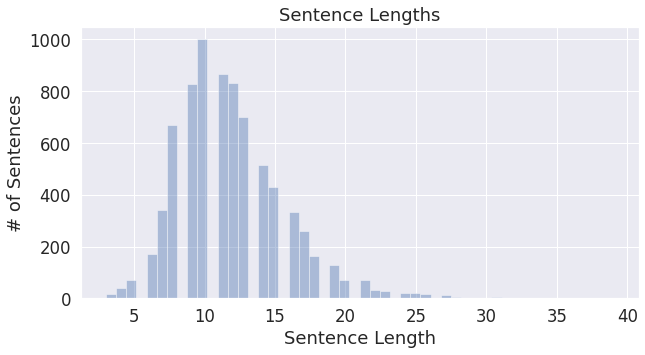

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

# Plot the distribution of comment lengths.
sns.distplot(lengths, kde=False, rug=False)

plt.title('Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('# of Sentences')


On peut voir qu'il y a des phrases très courtes. Comme on ne connait pas la longueur maximale de la phrase la plus longue du jeu de test, on la met à 50.


## 3.2. Nouvelle segmentation avec BERT

Nous utilisons la fonction `tokenizer.encode_plus` qui permet de:

1. Scinder les mots inconnus en parties de mots (subwords).
2. Ajouter les jetons spéciaux `[CLS]` et `[SEP]`.
3. Aligner les jetons avec leurs IDs.
4. Ajouter des Pad ou tronquer les phrases pour ne pas dépasser la longueur max.
5. Créer les masques d'attention qui différencient les "vrais" jetons des `[PAD]` et qui permettent à BERT et à son mécanisme d'auto-attention d'ignorer les `[PAD]`.


In [16]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:

    # Reconstruct the sentence--otherwise `tokenizer` will interpret the list
    # of string tokens as having already been tokenized by BERT.
    sent_str = ' '.join(sent)

    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent_str,                  # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation = True,
                        max_length = 50,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'][0])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'][0])

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print('Masks:', attention_masks[0])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  ['2', 'start', 'restaurants', 'with', 'inside', 'dining']
Token IDs: tensor([ 101, 1016, 2707, 7884, 2007, 2503, 7759,  102,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])
Masks: tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])


## 3.3. Ajouter les labels Null 

La nouvelle segmentation a ajouté un ensemble de jetons (spéciaux, pad, segmentation des mots inconnus) et nos labels originaux ne sont donc plus alignés avec nos jetons. 
Nous allons donc ajouter un label null pour ces nouveaux jetons.

Le dictionnaire aligne le jeton label à des IDs entiers unique. On en crée un nouveau d'ID `-100` pour les nouveaux jetons.

In [17]:
# New labels for all of the input sentences.
new_labels = []

# The special label ID we'll give to "extra" tokens.
null_label_id = -100

# For each sentence...
for (sen, orig_labels) in zip(input_ids, labels):
    
    # Create a new list to hold the adjusted labels for this sentence.
    padded_labels = []

    # This will be our index into the original label list.
    orig_labels_i = 0 

    # For each token in the padded sentence...
    for token_id in sen:

        # Pull the value out of the tensor.
        token_id = token_id.numpy().item()

        # If `[PAD]`, `[CLS]`, or `[SEP]`...
        if (token_id == tokenizer.pad_token_id) or \
            (token_id == tokenizer.cls_token_id) or \
            (token_id == tokenizer.sep_token_id):
            
            # Assign it the null label.
            padded_labels.append(null_label_id)

        # If the token string starts with "##"...
        elif tokenizer.ids_to_tokens[token_id][0:2] == '##':

            # It's a subword token, and not part of the original dataset, so
            # assign it the null label.
            padded_labels.append(null_label_id)

        # If it's not any of the above...
        else:
            
            # This token corresponds to one of the original ones, so assign it
            # it's original label.

            # Look up the label for this token.
            label_str = orig_labels[orig_labels_i]

            # Map the label to its ID, and assign it.
            padded_labels.append(label_map[label_str])

            # Increment our index into the original labels list.
            orig_labels_i += 1

    # If we did this right, then the new `padded_labels` list should match
    # the length of the tokenized sentence.
    assert(len(sen) == len(padded_labels))    

    # Store the updated labels list for this sentence.
    new_labels.append(padded_labels)


Exemple de phrase: "5 star resturants in my town" et son résultat après segmentation et remplacement des tokens :  Le premier sous-mot `rest` est associé au label original, tandis que  `##ura` et `##nts` ont pour label l'ID `-100`.


In [18]:
print('\nSentence:    ', sentences[2])
print('\nLabels:      ', labels[2])
print('\nBERT Tokens: ', tokenizer.tokenize(' '.join(sentences[2])))
print('\nToken IDs:   ', input_ids[2])
print('\nNew Labels:  ', new_labels[2])
print('\nMask:        ', attention_masks[2])



Sentence:     ['5', 'star', 'resturants', 'in', 'my', 'town']

Labels:       ['B-Rating', 'I-Rating', 'O', 'B-Location', 'I-Location', 'I-Location']

BERT Tokens:  ['5', 'star', 'rest', '##ura', '##nts', 'in', 'my', 'town']

Token IDs:    tensor([ 101, 1019, 2732, 2717, 4648, 7666, 1999, 2026, 2237,  102,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])

New Labels:   [-100, 13, 2, 10, -100, -100, 0, 14, 14, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]

Mask:         tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,

On transforme nos listes Python en tenseurs Pytorch :

In [19]:
# Convert the lists into PyTorch tensors.

# `input_ids` is a list of tensor arrays--stack them into a matrix with size
# [7,660  x  50].
pt_input_ids = torch.stack(input_ids, dim=0)

# `attention_masks` is a list of tensor arrays--stack them into a matrix with
# size [7,660  x  50].
pt_attention_masks = torch.stack(attention_masks, dim=0)

# Labels is a list of lists. Convert it into a tensor matrix with size 
# [7,660  x  50].
pt_labels = torch.tensor(new_labels, dtype=torch.long)

## 3.4. Entrainement et validation 

Division de l'ensemble d'entrainement en 90% train et 10% validation


In [20]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(pt_input_ids, pt_attention_masks, pt_labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

6,894 training samples
  766 validation samples


On utilise an iterator qui ne nécessite pas que tout l'ensemble de données soit en mémoire

In [21]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# 4. Entrainement du modèle de classification (affinage de BERT)

## 4.1. BertForTokenClassification

BERT + un couche linéaire pour la classification de chaque jeton. Cette couche est ensuite  sur la tâche de classification


In [22]:
# This is the number of labels in our dataset, so we will be doing 18-way classification (all labels plus our padding label)
len(label_map)

17

In [23]:
from transformers import BertForTokenClassification, AdamW, BertConfig

# Load BertForTokenClassification 
model = BertForTokenClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = len(label_map) + 1, # The number of output labels--18 for our NER dataset
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

## 4.2. Optimizer / Learning Rate Scheduler

In [24]:
# Load the AdamW optimizer
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate 
                  eps = 1e-8 # args.adam_epsilon 
                )


In [25]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs 
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

## 4.3. Boucle d'entrainement

In [26]:
import time
import numpy as np
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [27]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertfortokenclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.TokenClassifierOutput
        result = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = result.loss

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    216.    Elapsed: 0:00:23.
  Batch    80  of    216.    Elapsed: 0:00:46.
  Batch   120  of    216.    Elapsed: 0:01:09.
  Batch   160  of    216.    Elapsed: 0:01:31.
  Batch   200  of    216.    Elapsed: 0:01:54.

  Average training loss: 0.51
  Training epcoh took: 0:02:03

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    216.    Elapsed: 0:00:23.
  Batch    80  of    216.    Elapsed: 0:00:45.
  Batch   120  of    216.    Elapsed: 0:01:08.
  Batch   160  of    216.    Elapsed: 0:01:31.
  Batch   200  of    216.    Elapsed: 0:01:54.

  Average training loss: 0.23
  Training epcoh took: 0:02:02

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    216.    Elapsed: 0:00:23.
  Batch    80  of    216.    Elapsed: 0:00:45.
  Batch   120  of    216.    Elapsed: 0:01:08.
  Batch   160  of    216.    Elapsed: 0:01:31.
  Batch   200  of    216.    Elapsed: 0:01:53.

  Average training loss: 0.17
  Training 

On étudie notre perte sur l'ensemble d'entrainement sur tous les "batches"

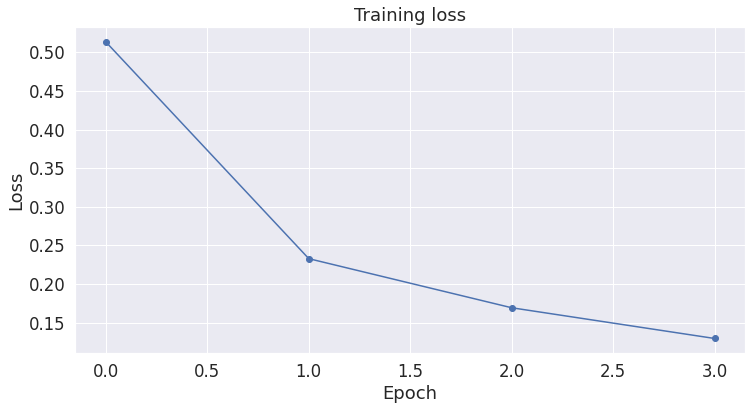

In [28]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# 5. Performance sur l'ensemble de test

### 5.1. Préparation des données

Mêmes étapes que pour les données d'entrainement pour l'ensemble de test "./restauranttest.bio"


In [29]:
import csv

# List of all sentences in the dataset.
sentences = []
labels = []

# Lists to store the current sentence.
tokens = []
token_labels = []

# Gather the set of unique labels.
unique_labels = set()

# Read the dataset line by line. Each line of the file
# is either empty or has two tokens, separated by a tab.
with open("./restauranttest.bio", newline = '') as lines:                                                                                          
    
    # Use the `csv` class to split the lines on the tab character.
    line_reader = csv.reader(lines, delimiter='\t')
    
    # For each line in the file...
    for line in line_reader:
        
        # If we encounter a blank line, it means we've completed the previous 
        # sentence. 
        if line == []:

            # Add the completed sentence.
            sentences.append(tokens)
            labels.append(token_labels)           
    
            # Start a new sentence.
            tokens = []
            token_labels = []        

        else: 
            # Add the token and its label to the current sentence.
            tokens.append(line[1])
            token_labels.append(line[0])

            # Add the label to the set (no effect if it already exists).
            unique_labels.add(line[0])
        


**Segmentation avec BERT**

In [30]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:

    # Reconstruct the sentence--otherwise `tokenizer` will interpret the list
    # of string tokens as having already been tokenized by BERT.
    sent_str = ' '.join(sent)

    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent_str,                  # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 50,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'][0])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'][0])

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print('Masks:', attention_masks[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  ['a', 'four', 'star', 'restaurant', 'with', 'a', 'bar']
Token IDs: tensor([ 101, 1037, 2176, 2732, 4825, 2007, 1037, 3347,  102,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])
Masks: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])


**Labels Null**

In [31]:
# New labels for all of the input sentences.
new_labels = []

# The special label ID we'll give to "extra" tokens.
null_label_id = -100

# For each sentence...
for (sen, orig_labels) in zip(input_ids, labels):
    
    # Create a new list to hold the adjusted labels for this sentence.
    padded_labels = []

    # This will be our index into the original label list.
    orig_labels_i = 0 

    # For each token in the padded sentence...
    for token_id in sen:
        
        # Pull the value out of the tensor.
        token_id = token_id.numpy().item()

        # If `[PAD]`, `[CLS]`, or `[SEP]`...
        if (token_id == tokenizer.pad_token_id) or \
            (token_id == tokenizer.cls_token_id) or \
            (token_id == tokenizer.sep_token_id):
            
            # Assign it the null label.
            padded_labels.append(null_label_id)

        # If the token string starts with "##"...
        elif tokenizer.ids_to_tokens[token_id][0:2] == '##':

            # It's a subword token, and not part of the original dataset, so
            # assign it the null label.
            padded_labels.append(null_label_id)

        # If it's not any of the above...
        else:
            
            # This token corresponds to one of the original ones, so assign it
            # it's original label.

            # Look up the label for this token.
            label_str = orig_labels[orig_labels_i]

            # Map the label to its ID, and assign it.
            padded_labels.append(label_map[label_str])

            # Increment our index into the original labels list.
            orig_labels_i += 1

    # If we did this right, then the new `padded_labels` list should match
    # the length of the tokenized sentence.
    assert(len(sen) == len(padded_labels))    

    # Store the updated labels list for this sentence.
    new_labels.append(padded_labels)


In [32]:
print('\nSentence:    ', sentences[2])
print('\nLabels:      ', labels[2])
print('\nBERT Tokens: ', tokenizer.tokenize(' '.join(sentences[2])))
print('\nToken IDs:   ', input_ids[2])
print('\nMask:        ', attention_masks[2])
print('\nNew Labels:  ', new_labels[2])


Sentence:     ['any', 'bbq', 'places', 'open', 'before', '5', 'nearby']

Labels:       ['O', 'B-Cuisine', 'O', 'B-Hours', 'I-Hours', 'I-Hours', 'B-Location']

BERT Tokens:  ['any', 'bb', '##q', 'places', 'open', 'before', '5', 'nearby']

Token IDs:    tensor([  101,  2151, 22861,  4160,  3182,  2330,  2077,  1019,  3518,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

Mask:         tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])

New Labels:   [-100, 10, 6, -100, 10, 16, 9, 9, 0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 

**DataLoader**

In [33]:
# Convert the lists into PyTorch tensors.

# `input_ids` is a list of tensor arrays--stack them into a matrix.
pt_input_ids = torch.stack(input_ids, dim=0)

# `attention_masks` is a list of tensor arrays--stack them into a matrix.
pt_attention_masks = torch.stack(attention_masks, dim=0)

# Labels is a list of lists. Convert it into a tensor matrix.
pt_labels = torch.tensor(new_labels, dtype=torch.long)

In [35]:
# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(pt_input_ids, pt_attention_masks, pt_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

## 5.2. Evaluation sur l'ensemble de test


On peut utiliser notre modèle affiné pour générer des prédictions sur l'ensemble de test 


In [36]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(pt_input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      result = model(b_input_ids, 
                      token_type_ids=None, 
                      attention_mask=b_input_mask,
                      return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 1,521 test sentences...
    DONE.


On va maintenant évaluer ces prédictions avec la métrique f1_score 


In [37]:
from sklearn.metrics import f1_score

# First, combine the results across the batches.
all_predictions = np.concatenate(predictions, axis=0)
all_true_labels = np.concatenate(true_labels, axis=0)

print("After flattening the batches, the predictions have shape:")
print("    ", all_predictions.shape)

# Next, let's remove the third dimension (axis 2), which has the scores
# for all 18 labels. 

# For each token, pick the label with the highest score.
predicted_label_ids = np.argmax(all_predictions, axis=2)

print("\nAfter choosing the highest scoring label for each token:")
print("    ", predicted_label_ids.shape) 

# Finally, for the sake of scoring, we don't actually care about the different
# sentences--we just look at whether the model made correct predictions for the
# individual tokens.

# Eliminate axis 0, which corresponds to the sentences.
predicted_label_ids = np.concatenate(predicted_label_ids, axis=0)
all_true_labels = np.concatenate(all_true_labels, axis=0)

print("\nAfter flattening the sentences, we have predictions:")
print("    ", predicted_label_ids.shape)
print("and ground truth:")
print("    ", all_true_labels.shape)


After flattening the batches, the predictions have shape:
     (1521, 50, 18)

After choosing the highest scoring label for each token:
     (1521, 50)

After flattening the sentences, we have predictions:
     (76050,)
and ground truth:
     (76050,)


Avant d'évaluer, on enlèle les tokens étiquetés avec `null`
Dans un vrai système de NER : on ignorerait aussi les prédictions pour les jetons `[CLS]`, `[SEP]`, et `[PAD]` et on utiliserait la prédiction du premier sous-mot pour toutes les parties du mot

In [38]:
# Construct new lists of predictions which don't include any null tokens.
real_token_predictions = []
real_token_labels = []

# For each of the input tokens in the dataset...
for i in range(len(all_true_labels)):

    # If it's not a token with a null label...
    if not all_true_labels[i] == -100:
        
        # Add the prediction and the ground truth to their lists.
        real_token_predictions.append(predicted_label_ids[i])
        real_token_labels.append(all_true_labels[i])

print("Before filtering out `null` tokens, length = {:,}".format(len(all_true_labels)))
print(" After filtering out `null` tokens, length = {:,}".format(len(real_token_labels)))


Before filtering out `null` tokens, length = 76,050
 After filtering out `null` tokens, length = 14,256


In [39]:
from sklearn.metrics import f1_score

# Calculate the F1 score. Because this is a multi-class problem, we have
# to set the `average` parameter. TODO - What does `micro` do?
f1 = f1_score(real_token_labels, real_token_predictions, average='micro') 

print ("F1 score: {:.2%}".format(f1))

F1 score: 91.91%


##  Sauvegarder et charger un modèle affiné 

In [40]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

In [41]:
!ls -l --block-size=K ./model_save/

total 425740K
-rw-r--r-- 1 root root      2K Oct 30 16:43 config.json
-rw-r--r-- 1 root root 425494K Oct 30 16:43 pytorch_model.bin
-rw-r--r-- 1 root root      1K Oct 30 16:43 special_tokens_map.json
-rw-r--r-- 1 root root      1K Oct 30 16:43 tokenizer_config.json
-rw-r--r-- 1 root root    227K Oct 30 16:43 vocab.txt


Le fichier le plus large consiste en les poids du modèl (418 megaoctets)

In [42]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

-rw-r--r-- 1 root root 416M Oct 30 16:43 ./model_save/pytorch_model.bin


In [ ]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive

drive.mount('/content/drive')

In [ ]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ "./drive/BERT Fine-Tuning/"

Chargement:

In [ ]:
# Load a trained model and vocabulary that you have fine-tuned
model = model_class.from_pretrained(output_dir)
tokenizer = tokenizer_class.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)